## Import Packages

In [1]:
import numpy as np
import nexfile # a .py file
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io
import scipy.linalg
import scipy.stats

## Data Loading Functions

In [2]:
def loadnpz(name, allow_pickle=False):
    """
    loadnpz loads compressed files
    Args:
       name (str): directory of npz file
       allow_pickle (bool): argument to allow pickle
    Returns:
       data (np array): np array from compressed npz file
    """
    if allow_pickle:
        data = np.load(name, allow_pickle=True)  # Over-rule default False (loading pickled data can execute arbitrary code)
    else:
        data = np.load(name)
    data = data.f.arr_0  # Gets np array from data, which is currently an instance of class NpzFile, which has f attribute (numpy.lib.npyio.NpzFile)
    return data

def loadFileNames(data_dir):
    """
    Gives the names of the files in the folder folderName1, which is simply the numeric data folders from /Rodent WFU DNMS
    Args:
        None.
    Returns:
        fileNames (list): list of all .nex filenames as full directory name as str (./Rodent_WFU_DNMS/1193/1193u044merge-clean.nex)
    """
    dir_name =  data_dir + '/driveNeuron' # Local directory as string for Rodent WFU DNMS
    folderNames = os.listdir(dir_name) # Get list for directory contents
    rat_nums = [] # List to append folders with integer name as rats' id
    
    # If subdirectory in list is integer then add to list rat_nums
    for num in folderNames: 
        try:
            int(num)
            rat_nums.append(num)
        except:
            True    
    
    fileNames = [] # the full directory of each event for all the rats
    
    # Generate list of all WFU Rat DMS file names with full directory name
    for num in rat_nums: 
        folder = dir_name + "/" + num + "/" # folder directory for each rat
        events = os.listdir(folder) # list of one rat's .nex file name for each event
        for a in range(len(events)): 
            events[a] = folder + events[a] # concatenate the full directory name for each event .nex file
        fileNames = fileNames + events 

    return fileNames

In [3]:
# ***Change this according to local directory***
data_dir = '/Volumes/TOSHIBA/data'

## Classes Defined

In [4]:
class ConstantModel(nn.Module):
    """
    ConstantModel class initializes the Z matrix for the latent dimension representation of the difference between
    datasets that is used after the embedding matrices are already training and held constant.
    Args:
        numData (int): number of data examples in design matrix
        codeSize (int): dimension of z, the latent dimension representation of the difference between datasets
    Returns:
        code (Tensor, dim=[1,z]): z for the dataKeys passed as argument
    """
    def __init__(self, numData, codeSize):
        super(ConstantModel, self).__init__()
        self.codeSize = codeSize
        self.numData = numData  # print (self.numData)
        self.code = nn.Parameter(torch.FloatTensor(np.random.random((numData, codeSize)) - 0.5))    # Random initialization of Z for all data examples

    def forward(self, dataKeys):
        code = self.code
        code = code[dataKeys]   # Code reset to Z for the dataKeys passed as argument: dim=(1,Z)
        return code

In [5]:
class SimpleNet3(nn.Module):
    """
    SimpleNet3 class generates Stefan's results for rat data and for simulation data but NOT for human data
    Args:
        codeSize (int): dimension of z, the latent dimension representation of the difference between datasets
        wireNum (np array (vector), dim=[1,num_recorded_neurons]): np array of wire index of each recorded neuron
    Returns:
        code (Tensor, dim=(1,z)): z for the dataKeys passed as argument
    Special:
    Stefan commented-out hyper-parameter attempts were codeSize: {10,>10}, codeNeuron:{4,20}, N1:{10,20}, N2:{20,30},
    codeN1: {20,40,400}, f1 fit length: {5,10,20}
    N2 appears hard coded but never used so was removed by Bryan
    """
    def __init__(self, codeSize, wireNum):
        super(SimpleNet3, self).__init__()
        self.originalNeuron = wireNum.shape[0]  # Recorded neurons as length of np array vector of wires by their indices, int
        self.codeNeuron = 20    # Logical neurons (latent space representation of recorded neurons; M in v1 model fig), int
        # N1 = 20 # This is what Stefan calls M in his figures, the number of logical neurons (the same as codeNeuron?)

        self.filter1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(1, 20), stride=(1, 20))   # f1 layer, output dim = (batch,20,M,0.05*T)
        self.filter2 = nn.Conv2d(in_channels=20, out_channels=5, kernel_size=(1, 1), stride=(1, 1))     # f2 layer, output dim = (batch,20,M,0.05*T)

        numWire = np.unique(wireNum).shape[0]   # Number of unique wires from this recording
        cellMatrix = torch.zeros((wireNum.shape[0], numWire))   # Create all zero tensor, dim=(num_recorded_neurons,num_unique_wires), tensor
        cellMatrix[np.arange(wireNum.shape[0]), wireNum] = 1    # Double indexing to create one-hot-matrix for each recorded neuron's respective wire index, tensor
        self.cellMatrix = cellMatrix
        self.numWire = numWire
        self.cellChannel = 2    # Hard-coded number of "cells" in Stefan's nomenclature. This is NOT an actual torch channel. See Fig v1.

        codeN1 = 20    # Dimension of output from first fully connected layer in linear layers from Z_s to E_s in Fig v1
        self.codeN1 = codeN1
        self.linCode0 = torch.nn.Linear(codeSize, codeN1)  # First fully connected layer Z_s to intermediate for eventual E2, FC1 in Fig v1
        self.linCode1 = torch.nn.Linear(codeN1, self.numWire * self.codeNeuron * self.cellChannel)  # Second fully connected layer intermediate to E2, FC2 in Fig v1
        self.linCell0 = torch.nn.Linear(codeSize, codeN1)  # First fully connected layer Z_s to intermediate again for eventual E1
        self.linCell1 = torch.nn.Linear(codeN1, self.originalNeuron * self.cellChannel)  # Second fully connected layer intermediate to E1
        self.lin1 = torch.nn.Linear(self.codeNeuron * 25, 6)  # Third fully connected layer, FC3 in Fig v1 (N1 to self.codeNeuron)
        self.nonlin = torch.tanh  # Nonlinear activation function

    def forward(self, x, z, returnEncode=False, runInput=True):
        # Args: x = N neurons x T timesteps training example, z = codeSize ?
        z1 = self.linCell0(z)
        z1 = self.nonlin(z1)
        cellEncode = self.linCell1(z1)  # Output is E1, called cellEncode, dim=(W*2*4)
        cellEncode = (torch.tanh(cellEncode) + 1) / 2   # Map cellEncode to 0-1

        z2 = self.linCode0(z)
        z2 = self.nonlin(z2)
        encodeNeuron = self.linCode1(z2)    # Output is E2, called encodeNeuron
        encodeNeuron = encodeNeuron.reshape((z.shape[0], self.numWire * self.cellChannel, self.codeNeuron))    # Reshape from (batch,2WM) to (batch,2W,M)
        encodeNeuron = torch.softmax(encodeNeuron, axis=1)  # Softmax so each row sums to 1 (each neron is now a weighted sum to 1 of new logical neurons)

        if runInput:
            cellEncode = cellEncode.repeat_interleave(x.shape[2])  # dim=(batch,W*2*4)=(batch,8W) to dim=(batch,T8W) ?
            cellEncode = cellEncode.reshape((x.shape[0], x.shape[1], self.cellChannel, x.shape[2]))  # (batch,T8W)=(batch,T*2*4W)=(batch,T*2*N) to (batch,N,2,T)
            x = x.reshape((x.shape[0], x.shape[1], 1, x.shape[2]))  # (batch,N,T) to (batch,N,1,T)
            x = x * cellEncode  # Output dim = dim(cellEncode) = (batch,N,2,T)
            x = x.reshape((x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))  # (batch,N,2,T) to (batch,N,2T)
            x = torch.swapaxes(x, 1, 2)  # (batch,N,2T) to (batch,2T,N)
            x = torch.matmul(x, self.cellMatrix)  # Output dim = (batch,2T,num_unique_wires)
            x = x.reshape((x.shape[0], self.cellChannel, x.shape[1] // self.cellChannel, x.shape[2]))  # (batch,2T,W) to (batch,2,T,W)
            x = torch.swapaxes(x, 1, 2)  # (batch,2,T,num_unique_wires) to (batch,T,2,W)
            x = x.reshape((x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))  # (batch,T,2,W) to (batch,T,2W)
            x = torch.matmul(x, encodeNeuron)  # Output dim = (batch,T,M)
            x = torch.swapaxes(x, 1, 2)  # (batch,T,M) to (batch,M,T)
            x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2]))  # (batch,M,T) to (batch,1,M,T)
            x = self.filter1(x)  # Output dim = (batch,20,M,0.05*T)
            x = self.nonlin(x)
            x = self.filter2(x)  # Output dim = (batch,5,M,0.05*T)
            x = self.nonlin(x)
            x = x.reshape((x.shape[0], x.shape[1] * x.shape[2], x.shape[3]))  # (batch,5,M,0.05*T) to (batch,5M,0.05*T)
            x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))  # (batch,5M,0.05*T) to (batch,0.25*M*T)
            x = self.lin1(x)  # Output dim = (batch,6)

        if returnEncode:
            encodeNeuron = encodeNeuron.reshape((encodeNeuron.shape[0], 2, encodeNeuron.shape[1] // 2, encodeNeuron.shape[2]))  # (batch,2W,M) to (batch,2,W,M)
            encodeNeuron = torch.transpose(encodeNeuron, 1, 2)  # (batch,2,W,M) to (batch,W,2,M)
            encodeNeuron = encodeNeuron.reshape((encodeNeuron.shape[0], encodeNeuron.shape[1] * encodeNeuron.shape[2], encodeNeuron.shape[3]))  # (batch,W,2,M) to (batch,2W,M)
            return x, encodeNeuron  # returns same shape as initial input encodeNeuron but rows are not in same original order
        else:
            return x

In [6]:
# modelType = ['No Session Representations', 'With Session Representations', 'Rat Specific Representations*', 'Using Trained Session Representations']
# mod_num = np.size(modelType)

In [7]:
# Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
# Accuracy Summary Table
import pandas as pd
from statistics import mean
# Representation Visualization
from mpl_toolkits import mplot3d
%matplotlib notebook 
# using notebook for interactive figure instead of inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


In [8]:
import matplotlib as mpl
mpl.is_interactive() 
plt.ion() # to turn interactive back on plt.ion()

## Summary

In [22]:
# eventNames = loadnpz(data_dir+'/eventData/seperate/outputNames_exp_rm.npz')
eventNames = np.array(eventNames)
fileLabel_dict = {
#                   "AM&S": [0,4], 
#                   "ANM&S": [1,4], 
#                   "BM&S": [2,5], 
#                   "BNM&S": [3,5], 
#                   "AM&NM&S": [0,1,4], 
#                   "BM&NM&S": [2,3,5]
                    'exp_org',
                    'exp_rm'
                    }



t = np.arange(100)
XtimeInt_dict = {
#                 "-5to5": t, 
#                 "-3to5": t[20:], 
#                 "-5to3": t[:-20], 
                "-3to3": t[20:-20], 
                "-3to1": t[20:-40], 
                "-1to3": t[40:-20], 
                "-2to2": t[30:-30],
#                 "-1.5to1.5": t[35:-35],
                "-1to1": t[40:-40] 
                } #, np.concatenate((np.arange(40), np.arange(40)+60)), t[60:]]
    
count = 0

accu_results_dict = {}
    
for i in fileLabel_dict:
#     print(i, fileLabel_dict[i]) # i = fileLabel
#     print("Included Events",eventNames[fileLabel_dict[i]]) # eventNames
#     X = loadnpz(data_dir + '/eventData/combined/data_' + i + '.npz') # (x, y, z) x = total events, y = neurons, z = timeframe
#     print(i, np.shape(X))
    for j in XtimeInt_dict:
#         print("Time Interval is: ", j, len(XtimeInt_dict[j]))
        
        for k in ["", "Rat"]:
            print(k,i,j)
            
            # CONFUSION MATRIX
#             cm = np.load(data_dir + '/neuronModel/cm_' + k + i + j + '.npy')
#             # Normalize the confusion matrix to between 0 and 1
#             cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#             fig, ax = plt.subplots(figsize=(10,10))
#             sn.heatmap(cmn, annot=True, fmt='.2f', xticklabels=eventNames, yticklabels=eventNames)
#             plt.ylabel('Actual')
#             plt.xlabel('Predicted')
#             plt.title(i+j+k, fontsize = 25)
#         #     plt.show(block=False)
#             plt.savefig(data_dir + '/analysisGraphics/cm_' + k + i + j + '.jpg')

            
            
            # codeModel VISUALIZATION
#             codeModel = torch.load(data_dir + '/neuronModel/codeModel_' + k + i + j + '.pt')
#             for name, param in codeModel.named_parameters():
#                 print(name, param.size())
#                 z = param.detach().numpy()
#         #         print("Number of Rows: ", len(z))
#         #         print("Number of Columns: ", len(z[0]))
#                 xdata = np.array([np.linspace(1,len(z), len(z))]*len(z[0])).T #.flatten()
#                 ydata = np.array([np.linspace(1,len(z[0]),len(z[0]))]*len(z))#.flatten()
#                 zdata = z
#                 fig, ax = plt.subplots(figsize=(10,10))
#                 ax = plt.axes(projection='3d')
#                 rep = ax.plot_wireframe(xdata, ydata, zdata, rstride=10, cstride=10, linewidth=0.5, alpha = 0.7)
#                 plt.title(i+j+k, fontsize = 30)
#                 plt.xlabel('Sessions')
#                 plt.ylabel('Size of Low Dimentionl Representations')
#                 plt.show()

    
    
            # ACCURACY SUMMARY TABLE
#             accu = np.load(data_dir + '/neuronModel/accuracy_' + k + i + j + '.npy',allow_pickle=True)
#             train_accu = np.load(data_dir + '/neuronModel/trainAccuracy_'+k+i+j+'.npy', allow_pickle=True)
#             test_accu = np.load(data_dir + '/neuronModel/testAccuracy_'+k+i+j+'.npy', allow_pickle=True)
            
#             accu_results_dict[str(j+k+i)] = [mean(d for d in accu if d is not None), train_accu[-1], test_accu[-1]]

            count+=1
            print("Complete " + k + i + j + f"({count})")

# accu_results = pd.DataFrame([([k] + v) for k, v in accu_results_dict.items()], columns=['Models', 'Mean Accuracy of Representations', 'Train Accuracy', 'Test Accuracy']).set_index(np.arange(1,count+1))
# accu_results = accu_results.round(3)
# accu_results.to_csv(data_dir + f'/analysisGraphics/AccuracySummary0130_{count}.csv')

 exp_org -3to3
Complete exp_org-3to3(1)
Rat exp_org -3to3
Complete Ratexp_org-3to3(2)
 exp_rm -3to3
Complete exp_rm-3to3(3)
Rat exp_rm -3to3
Complete Ratexp_rm-3to3(4)
 exp_org -3to1
Complete exp_org-3to1(5)
Rat exp_org -3to1
Complete Ratexp_org-3to1(6)
 exp_rm -3to1
Complete exp_rm-3to1(7)
Rat exp_rm -3to1
Complete Ratexp_rm-3to1(8)
 exp_org -1to3
Complete exp_org-1to3(9)
Rat exp_org -1to3
Complete Ratexp_org-1to3(10)
 exp_rm -1to3
Complete exp_rm-1to3(11)
Rat exp_rm -1to3
Complete Ratexp_rm-1to3(12)
 exp_org -2to2
Complete exp_org-2to2(13)
Rat exp_org -2to2
Complete Ratexp_org-2to2(14)
 exp_rm -2to2
Complete exp_rm-2to2(15)
Rat exp_rm -2to2
Complete Ratexp_rm-2to2(16)
 exp_org -1to1
Complete exp_org-1to1(17)
Rat exp_org -1to1
Complete Ratexp_org-1to1(18)
 exp_rm -1to1
Complete exp_rm-1to1(19)
Rat exp_rm -1to1
Complete Ratexp_rm-1to1(20)


In [23]:
accu_results

,Models,Mean Accuracy of Representations,Train Accuracy,Test Accuracy
1,-3to3exp_org,0.810,0.860,0.812
2,-3to3Ratexp_org,0.781,0.800,0.778
3,-3to3exp_rm,0.713,0.776,0.714
4,-3to3Ratexp_rm,0.683,0.705,0.688
5,-3to1exp_org,0.762,0.832,0.762
6,-3to1Ratexp_org,0.732,0.762,0.734
7,-3to1exp_rm,0.675,0.740,0.680
8,-3to1Ratexp_rm,0.658,0.675,0.661
9,-1to3exp_org,0.796,0.847,0.798
10,-1to3Ratexp_org,0.745,0.763,0.747


## Dec 15th Analysis

In [8]:
X = loadnpz(data_dir + '/eventData/combined/data_S|M & S|NM(NS).npz') 
# (x, y, z) x = total events, y = neurons, z = timeframe
print("Full dataset input: ", np.shape(X))

Full dataset input:  (95642, 152, 100)


In [9]:
Y = loadnpz(data_dir + '/eventData/combined/outputType_S|M & S|NM(NS).npz') 
print("Full dataset output: ", np.shape(Y), np.unique(Y))        

Full dataset output:  (95642,) [0. 1. 2. 3. 4. 5. 6. 7.]


In [10]:
eventNames = loadnpz(data_dir+'/eventData/seperate/outputNames_S|M & S|NM(NS).npz')
eventNames_dict = dict(zip(eventNames, np.unique(Y, return_counts=True)[1]))
eventNames_dict

{'A_MATCH': 5321,
 'A_NONMATCH': 18582,
 'B_MATCH': 5850,
 'B_NONMATCH': 18068,
 'A_S|M': 5321,
 'A_S|NM': 18582,
 'B_S|M': 5850,
 'B_S|NM': 18068}

In [11]:
X2 = loadnpz(data_dir + '/eventData/combined/data_6.npz')
# (x, y, z) x = total events, y = neurons, z = timeframe
print("Full dataset input: ", np.shape(X2))

Full dataset input:  (95786, 152, 100)


In [12]:
Y2 = loadnpz(data_dir + '/eventData/combined/outputType_6.npz') 
print("Full dataset output: ", np.shape(Y2), np.unique(Y2))    

Full dataset output:  (95786,) [0. 1. 2. 3. 4. 5.]


In [13]:
eventNames2 = loadnpz(data_dir+'/eventData/seperate/outputNames_6.npz')
eventNames_dict2 = dict(zip(eventNames2, np.unique(Y2, return_counts=True)[1]))
eventNames_dict2

{'A_MATCH': 5321,
 'A_NONMATCH': 18571,
 'A_SAMPLES': 23896,
 'B_MATCH': 5850,
 'B_NONMATCH': 18355,
 'B_SAMPLES': 23793}

In [19]:
labels = ['Rat6-1to1', '6-1to1', 'RatS|M & S|NM(NS)-1to1', 'S|M & S|NM(NS)-1to1']

In [25]:
# ACCURACY SUMMARY TABLE for Rat and Session Representation
accu_results_dict = {}

for i in labels:
    
    train_accu = np.load(data_dir + '/neuronModel/trainAccuracy_' + i + '.npy', allow_pickle=True)
    test_accu = np.load(data_dir + '/neuronModel/testAccuracy_' + i + '.npy', allow_pickle=True)
    accu = np.load(data_dir + '/neuronModel/accuracy_' + i + '.npy', allow_pickle=True)

#     print("RatS|M & S|NM-1to1 Iterations: ", len(train_accu))
#     print("Train Accuracy: ", train_accu[-1])
#     print("Test Accuracy: ", test_accu[-1])

    accu_results_dict[str(i)] = [np.shape(accu), mean(d for d in accu if d is not None), len(train_accu), train_accu[-1], test_accu[-1]]

accu_results = pd.DataFrame([([k] + v) for k, v in accu_results_dict.items()], columns=['Models', 'Representation Shape', 'Mean Accuracy of Representations', 'Number of Iterations', 'Train Accuracy', 'Test Accuracy']).set_index(np.arange(1,len(labels)+1))
accu_results = accu_results.round(3)
accu_results
# accu_results.to_csv(data_dir + f'/analysisGraphics/AccuracySummary1215.csv')

,Models,Representation Shape,Mean Accuracy of Representations,Number of Iterations,Train Accuracy,Test Accuracy
1,Rat6-1to1,"(59,)",0.715,81,0.732,0.715
2,6-1to1,"(519,)",0.744,88,0.806,0.745
3,RatS|M & S|NM(NS)-1to1,"(59,)",0.627,70,0.642,0.633
4,S|M & S|NM(NS)-1to1,"(519,)",0.652,101,0.720,0.656


In [16]:
# train_accu = np.load(data_dir + '/neuronModel/trainAccuracy_RatS|M & S|NM(NS)-1to1.npy', allow_pickle=True)
# test_accu = np.load(data_dir + '/neuronModel/testAccuracy_RatS|M & S|NM(NS)-1to1.npy', allow_pickle=True)
# print("RatS|M & S|NM-1to1 Iterations: ", len(train_accu))
# print("Train Accuracy: ", train_accu[-1])
# print("Test Accuracy: ", test_accu[-1])
           
# train_accu = np.load(data_dir + '/neuronModel/trainAccuracy_S|M & S|NM(NS)-1to1.npy', allow_pickle=True)
# test_accu = np.load(data_dir + '/neuronModel/testAccuracy_S|M & S|NM(NS)-1to1.npy', allow_pickle=True)
# print("S|M & S|NM-1to1 Iterations: ", len(train_accu))
# print("Train Accuracy: ", train_accu[-1])
# print("Test Accuracy: ", test_accu[-1])

# train_accu = np.load(data_dir + '/neuronModel/trainAccuracy_RatS|M & S|NM(NS)-2to2.npy', allow_pickle=True)
# test_accu = np.load(data_dir + '/neuronModel/testAccuracy_RatS|M & S|NM(NS)-2to2.npy', allow_pickle=True)
# print("RatS|M & S|NM-2to2 Iterations: ", len(train_accu))
# print("Train Accuracy: ", train_accu[-1])
# print("Test Accuracy: ", test_accu[-1])
           
# train_accu = np.load(data_dir + '/neuronModel/trainAccuracy_S|M & S|NM(NS)-2to2.npy', allow_pickle=True)
# test_accu = np.load(data_dir + '/neuronModel/testAccuracy_S|M & S|NM(NS)-2to2.npy', allow_pickle=True)
# print("S|M & S|NM-2to2 Iterations: ", len(train_accu))
# print("Train Accuracy: ", train_accu[-1])
# print("Test Accuracy: ", test_accu[-1])


RatS|M & S|NM-1to1 Iterations:  64
Train Accuracy:  0.6389441188781917
Test Accuracy:  0.6246076585059636
S|M & S|NM-1to1 Iterations:  99
Train Accuracy:  0.7209083298451234
Test Accuracy:  0.6574597196066123
RatS|M & S|NM-2to2 Iterations:  91
Train Accuracy:  0.6963949351192967
Test Accuracy:  0.6753504917346725
S|M & S|NM-2to2 Iterations:  88
Train Accuracy:  0.758724884889075
Test Accuracy:  0.6984201715840134


In [26]:
# CONFUSION MATRIX
# for i in ['RatS|M & S|NM(NS)-1to1', 'S|M & S|NM(NS)-1to1']: # ['Rat6-1to1', '6-1to1']: 
#     cm = np.load(data_dir + '/neuronModel/cm_' + i + '.npy')
#     # Normalize the confusion matrix to between 0 and 1
#     cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     fig, ax = plt.subplots(figsize=(10,10))
#     sn.heatmap(cmn, annot=True, fmt='.2f', xticklabels=eventNames, yticklabels=eventNames)
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.title(i, fontsize = 25)
#     #     plt.show(block=False)
#     plt.savefig(data_dir + '/analysisGraphics/cm_' + i + '.jpg')

            
            
# # codeModel VISUALIZATION

#     codeModel = torch.load(data_dir + '/neuronModel/codeModel_' + i + '.pt')
#     for name, param in codeModel.named_parameters():
#         print(name, param.size())
#         z = param.detach().numpy()
#     #         print("Number of Rows: ", len(z))
#     #         print("Number of Columns: ", len(z[0]))
#         xdata = np.array([np.linspace(1,len(z), len(z))]*len(z[0])).T #.flatten()
#         ydata = np.array([np.linspace(1,len(z[0]),len(z[0]))]*len(z))#.flatten()
#         zdata = z
#         fig, ax = plt.subplots(figsize=(10,10))
#         ax = plt.axes(projection='3d')
#         rep = ax.plot_wireframe(xdata, ydata, zdata, rstride=10, cstride=10, linewidth=0.5, alpha = 0.7)
#         plt.title(i + " (8 events)", fontsize = 30)
#         plt.xlabel('Sessions')
#         plt.ylabel('Size of Low Dimentionl Representations')
#         plt.show()

<IPython.core.display.Javascript object>


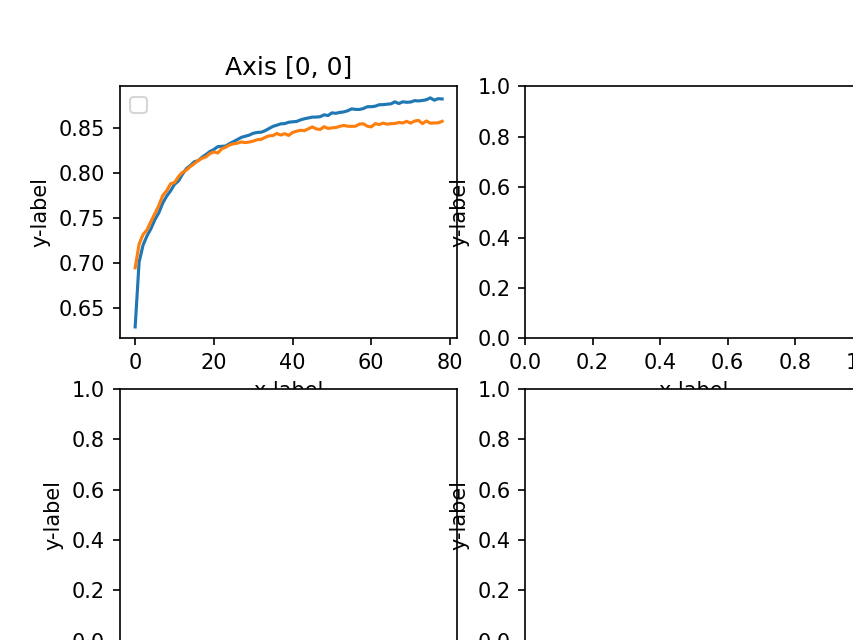

/var/folders/z6/2bl753g169d0q18lsv30hgf00000gn/T/ipykernel_55127/1011030631.py:5: UserWarning: The handle 'n' has a label of '_' which cannot be automatically added to the legend.
  axs[0, 0].legend("train_accu","test_accu")
/var/folders/z6/2bl753g169d0q18lsv30hgf00000gn/T/ipykernel_55127/1011030631.py:5: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axs[0, 0].legend("train_accu","test_accu")
/var/folders/z6/2bl753g169d0q18lsv30hgf00000gn/T/ipykernel_55127/1011030631.py:5: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axs[0, 0].legend("train_accu","test_accu")
/var/folders/z6/2bl753g169d0q18lsv30hgf00000gn/T/ipykernel_55127/1011030631.py:5: UserWarning: 

In [143]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(train_accu)
axs[0, 0].plot(test_accu)
axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 0].legend("train_accu","test_accu")
# axs[0, 1].plot(test_accu, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

## Confusion Matrix

AM&S [0, 4]
['A_MATCH' 'A_SAMPLES']


/var/folders/z6/2bl753g169d0q18lsv30hgf00000gn/T/ipykernel_55127/3358392695.py:13: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


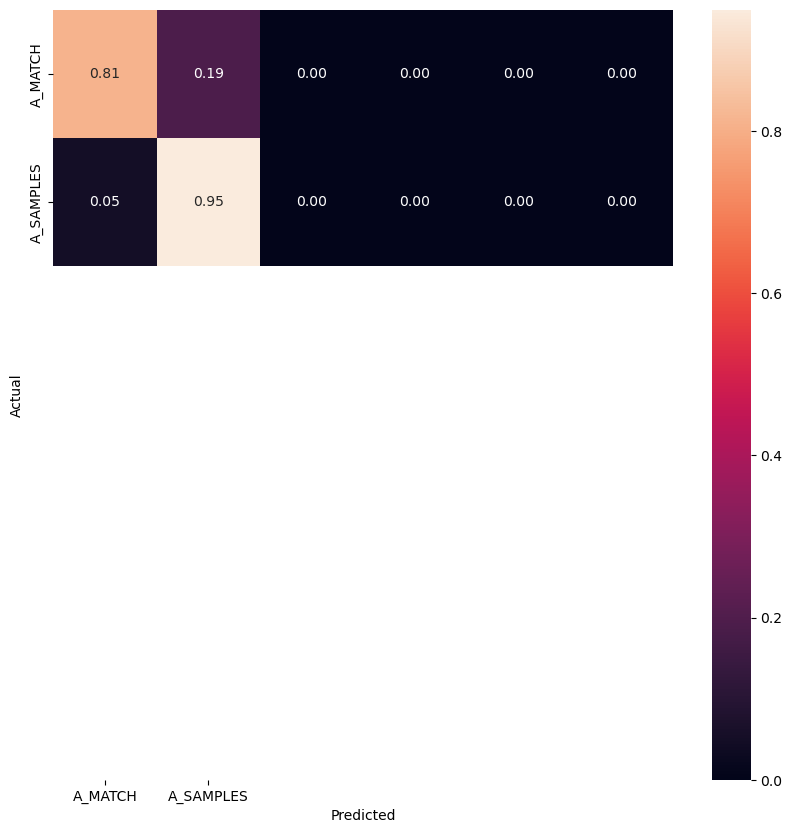

In [17]:
eventNames = ['A_MATCH', 'A_NONMATCH', 'B_MATCH', 'B_NONMATCH', 'A_SAMPLES', 'B_SAMPLES']
eventNames = np.array(eventNames)

fileLabel_dict = {"AM&S": [0,4]}#, "ANM&S": [1,4], "BM&S": [2,5], "BNM&S": [3,5]}

for i in fileLabel_dict:
    print(i, fileLabel_dict[i]) # i = fileLabel
    print(eventNames[fileLabel_dict[i]]) # eventNames
    
    cm = np.load(data_dir + '/neuronModel/cm_7.npy')

    # Normalize the confusion matrix to between 0 and 1
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10,10))
    sn.heatmap(cmn, annot=True, fmt='.2f', xticklabels=eventNames[fileLabel_dict[i]], yticklabels=eventNames[fileLabel_dict[i]])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.title("", fontsize = 25)
    #     plt.show(block=False)
    # plt.savefig(data_dir + '/analysisGraphics/cm_' + str(i) + '.jpg')

<IPython.core.display.Javascript object>


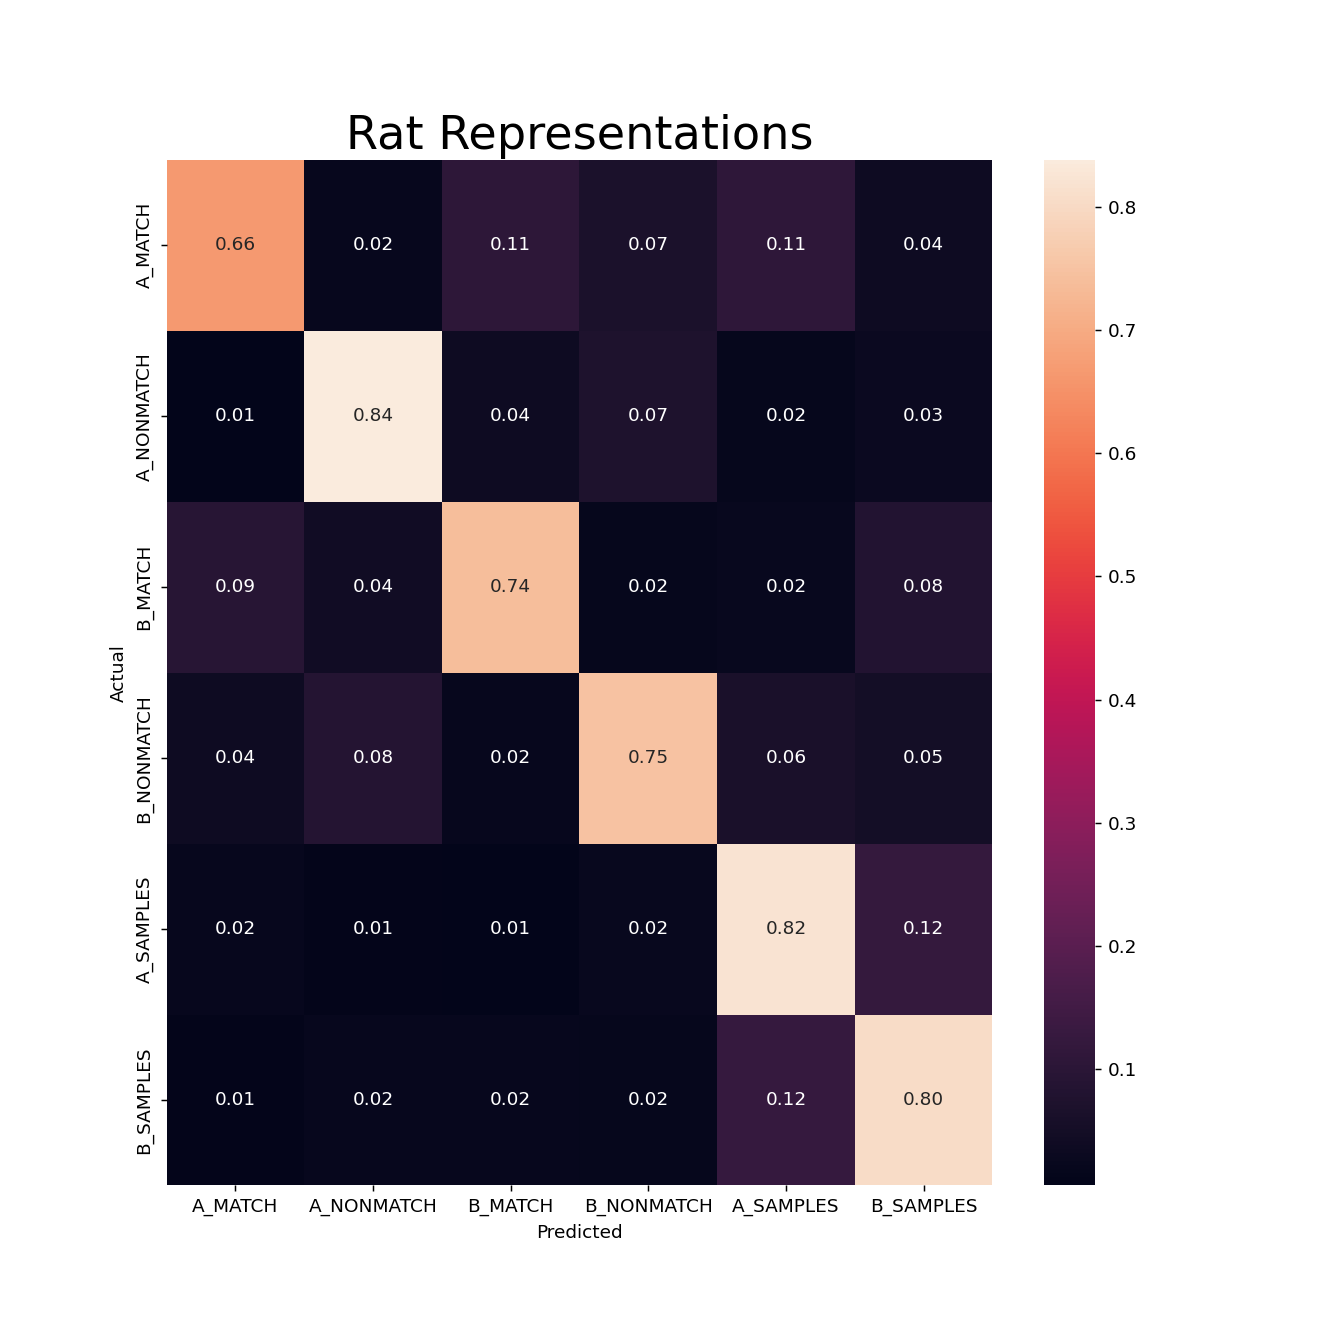

In [147]:
cm = np.load(data_dir + '/neuronModel/cm_7.npy')

# Normalize the confusion matrix to between 0 and 1
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(cmn, annot=True, fmt='.2f', xticklabels=eventNames, yticklabels=eventNames)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Rat Representations", fontsize = 25)

plt.savefig(data_dir + '/analysisGraphics/cm_7.jpg')

<IPython.core.display.Javascript object>


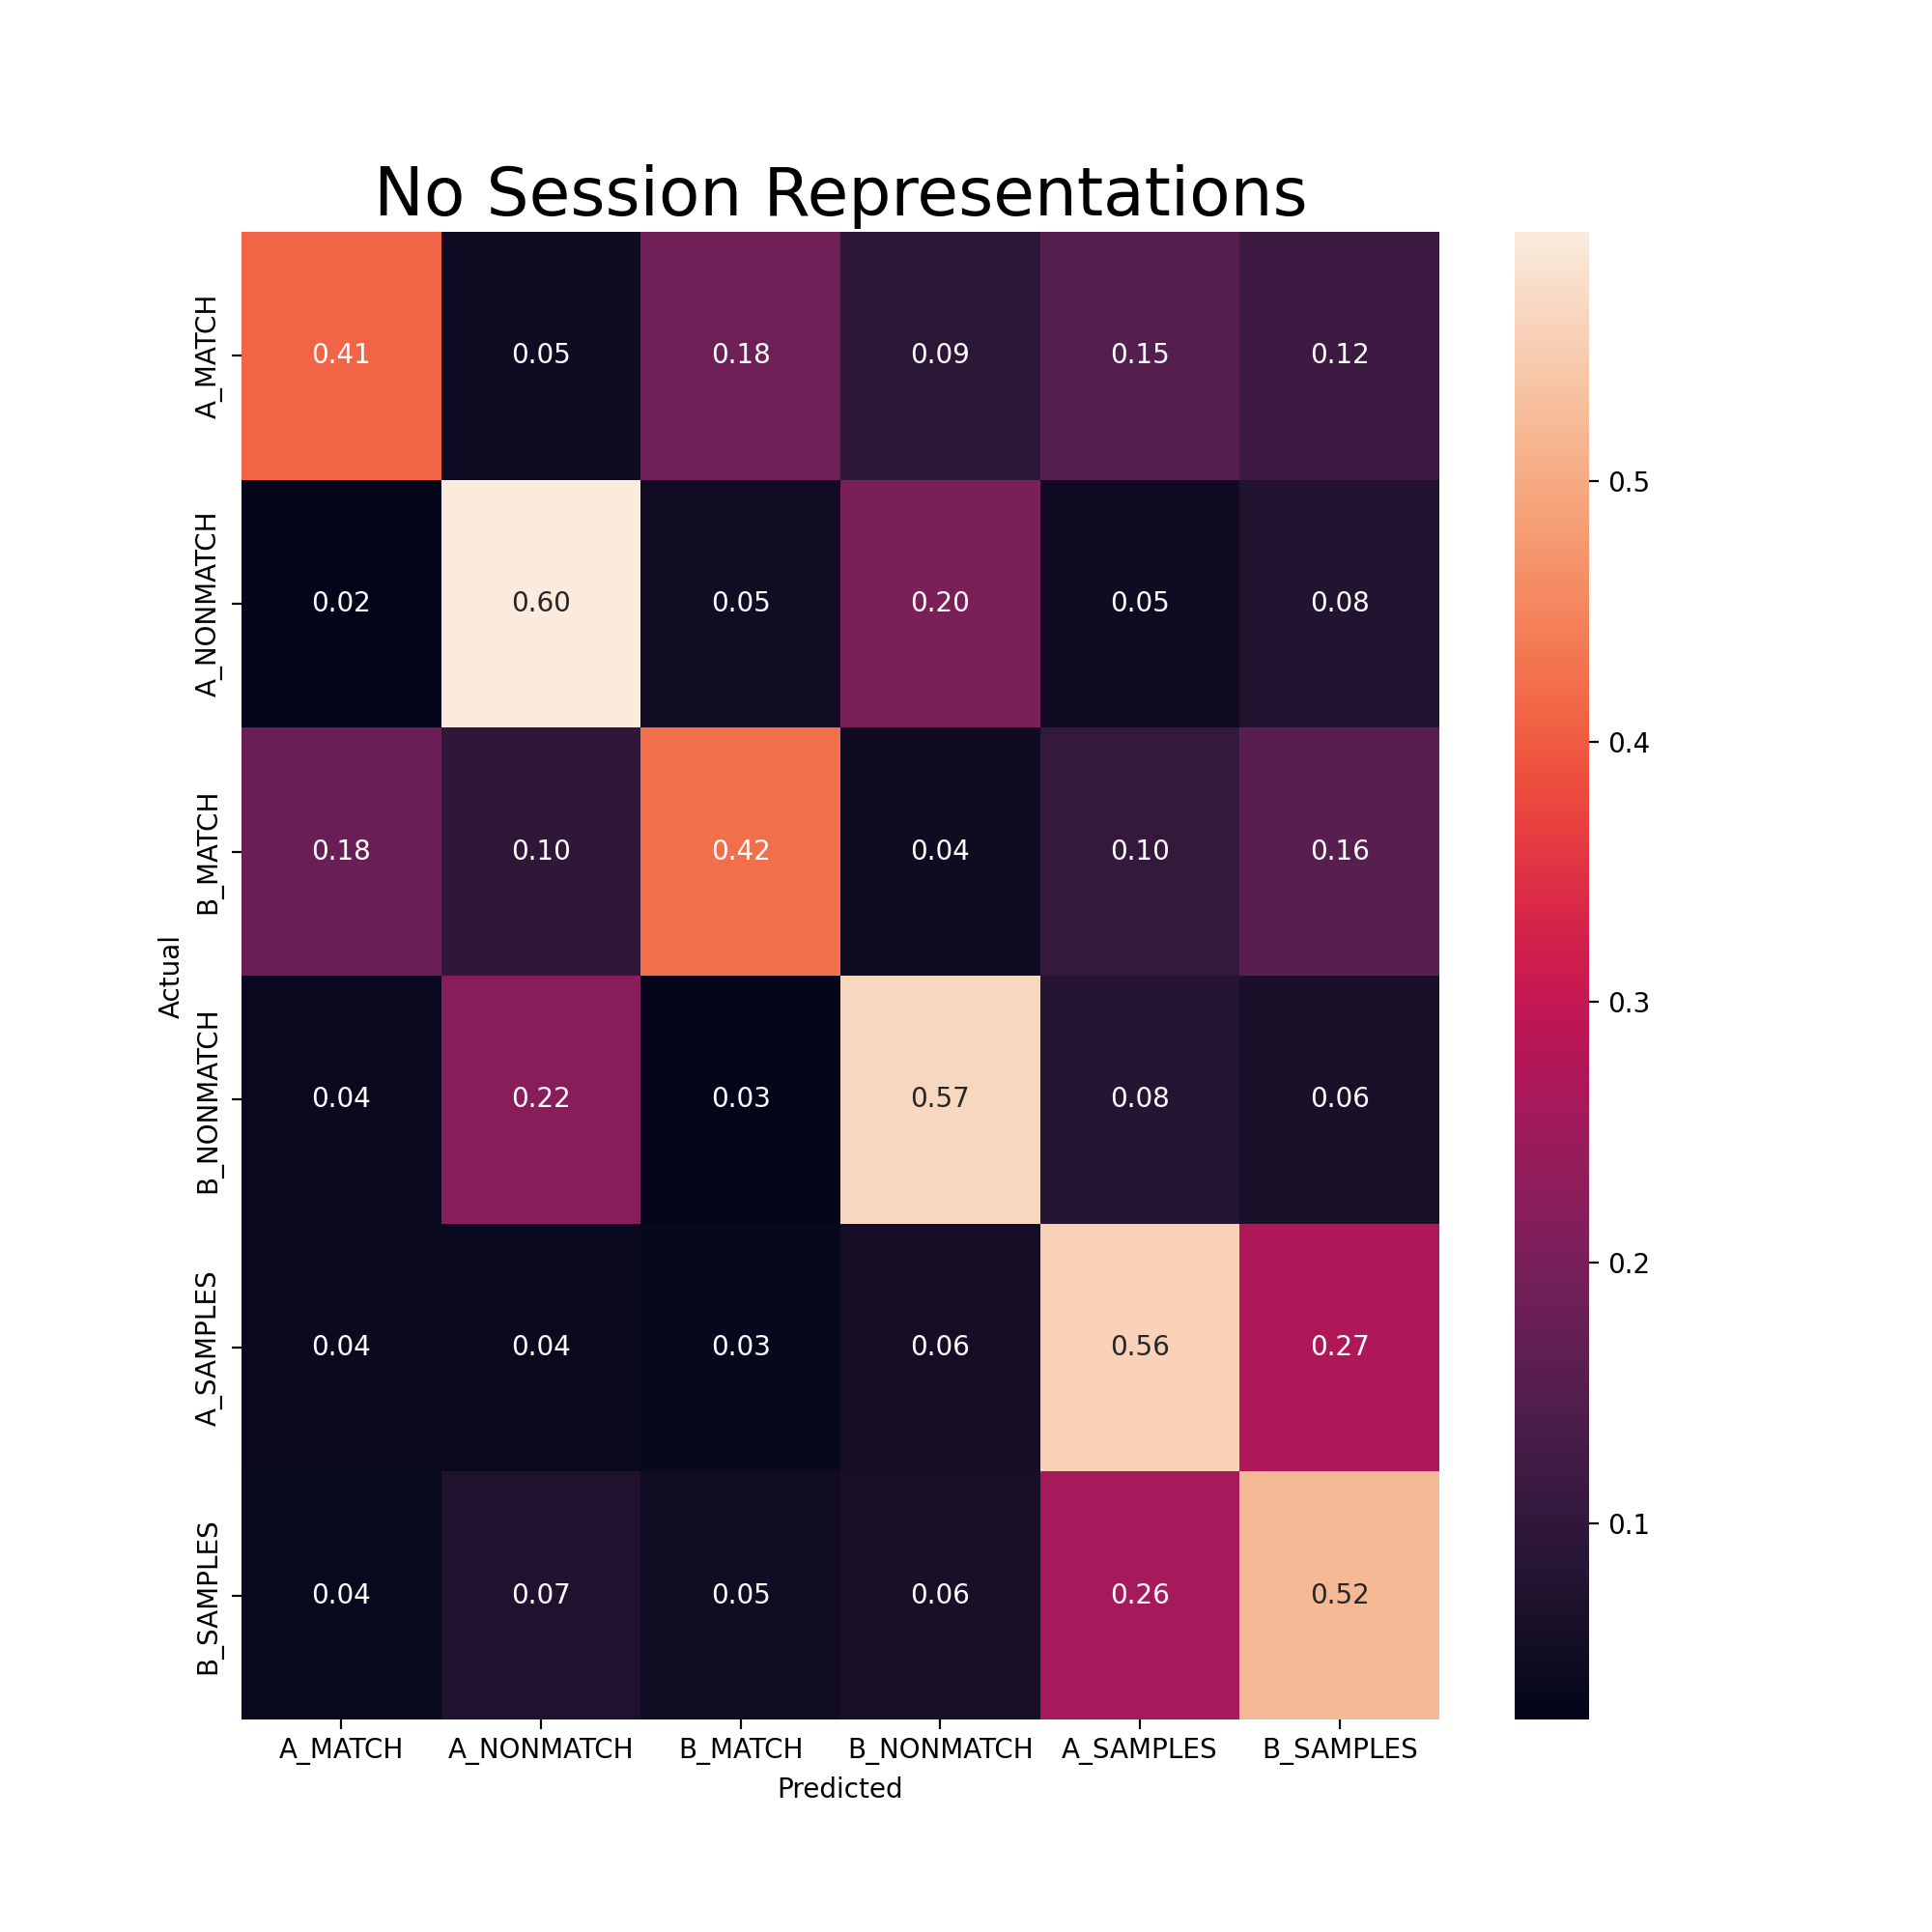

<IPython.core.display.Javascript object>


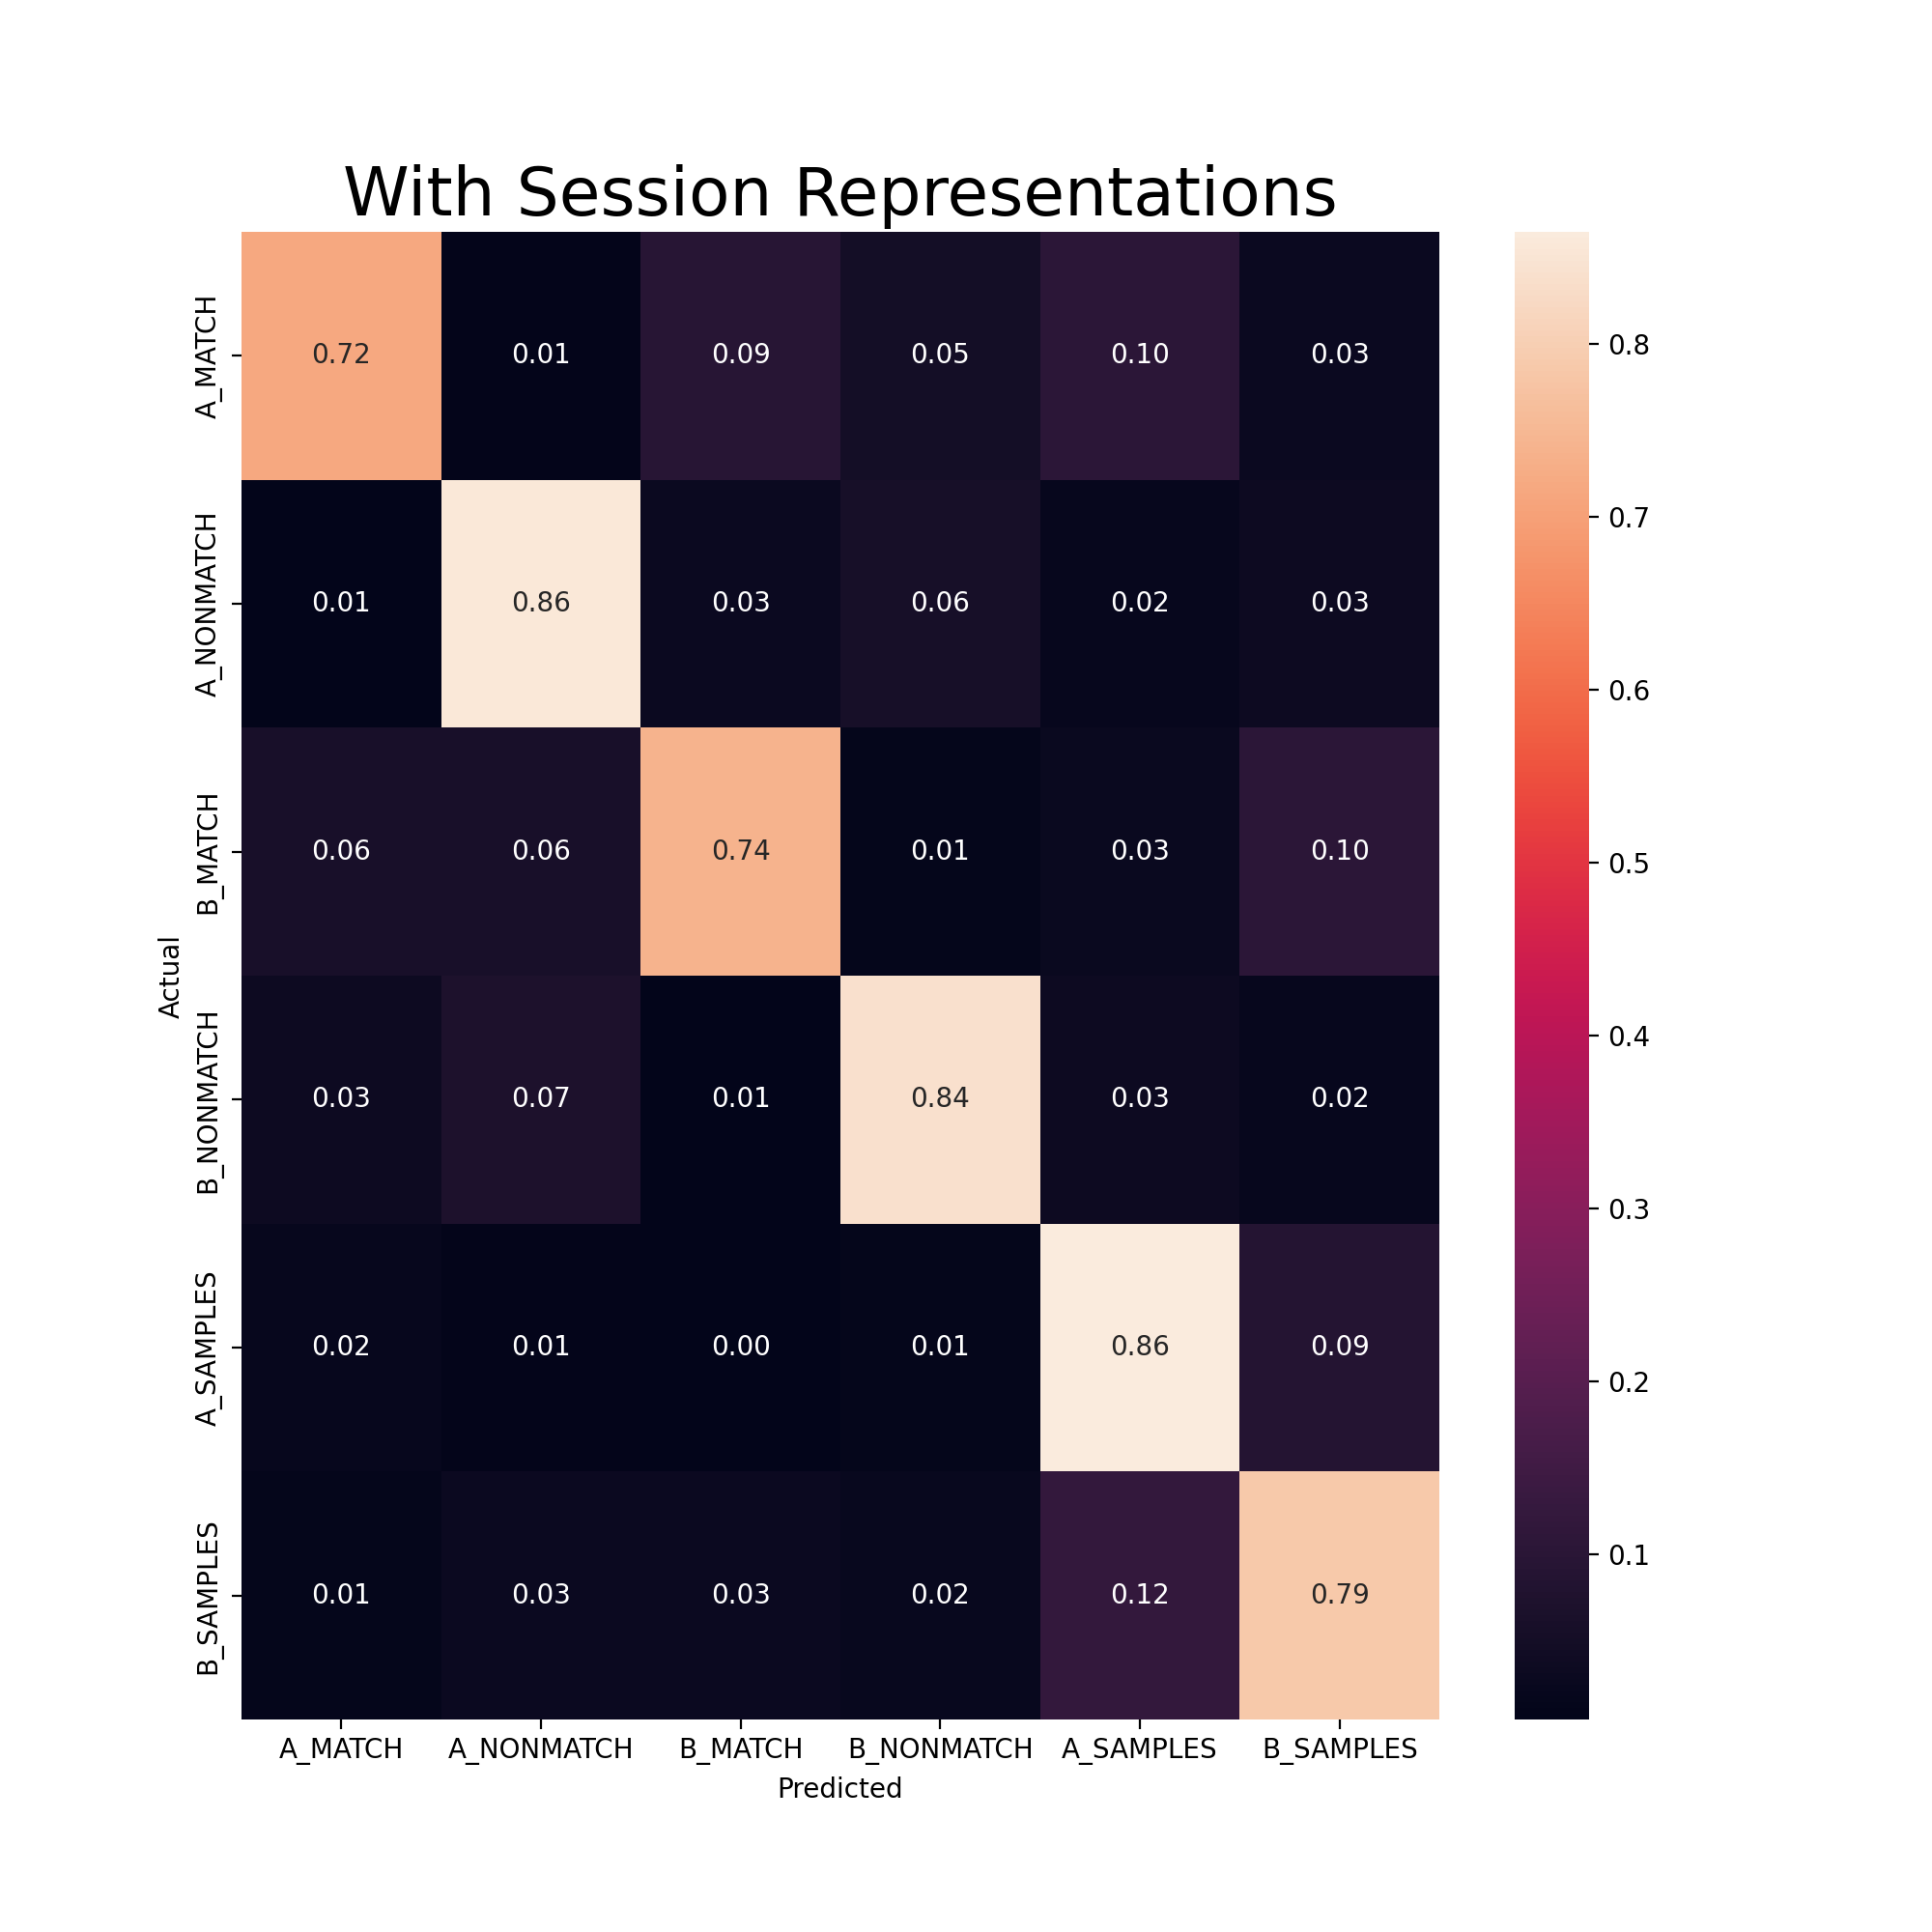

<IPython.core.display.Javascript object>


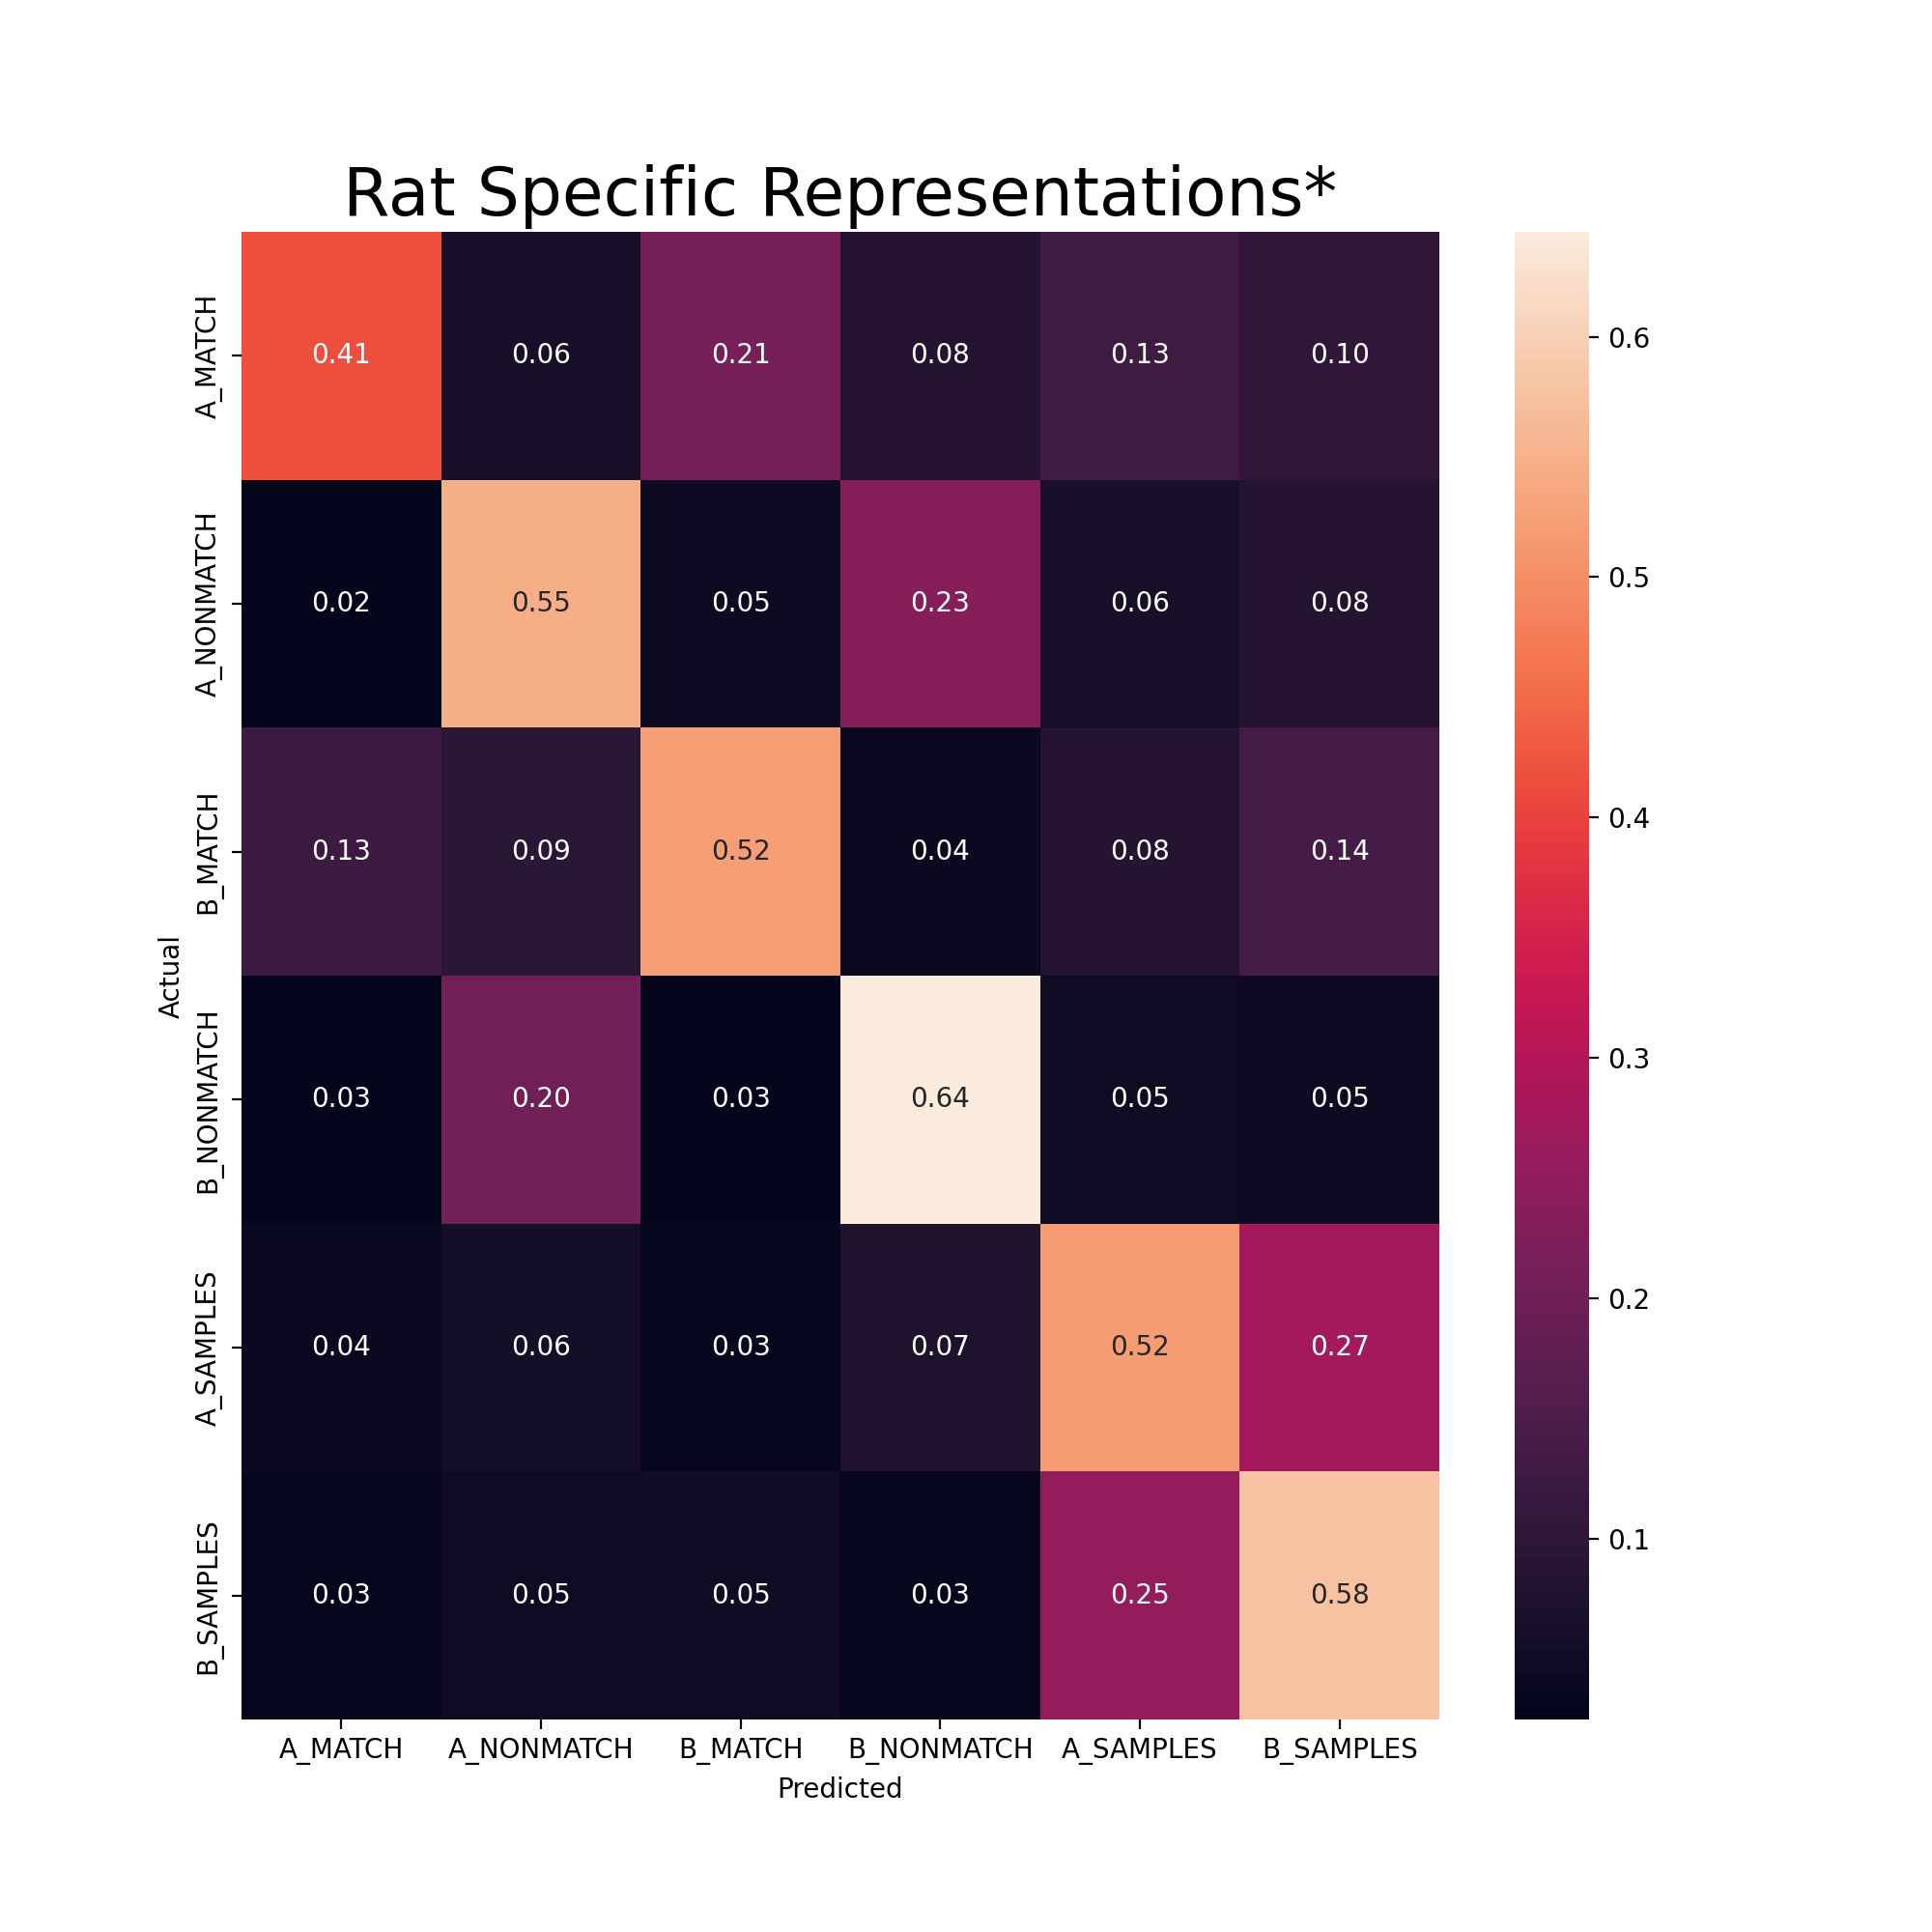

<IPython.core.display.Javascript object>


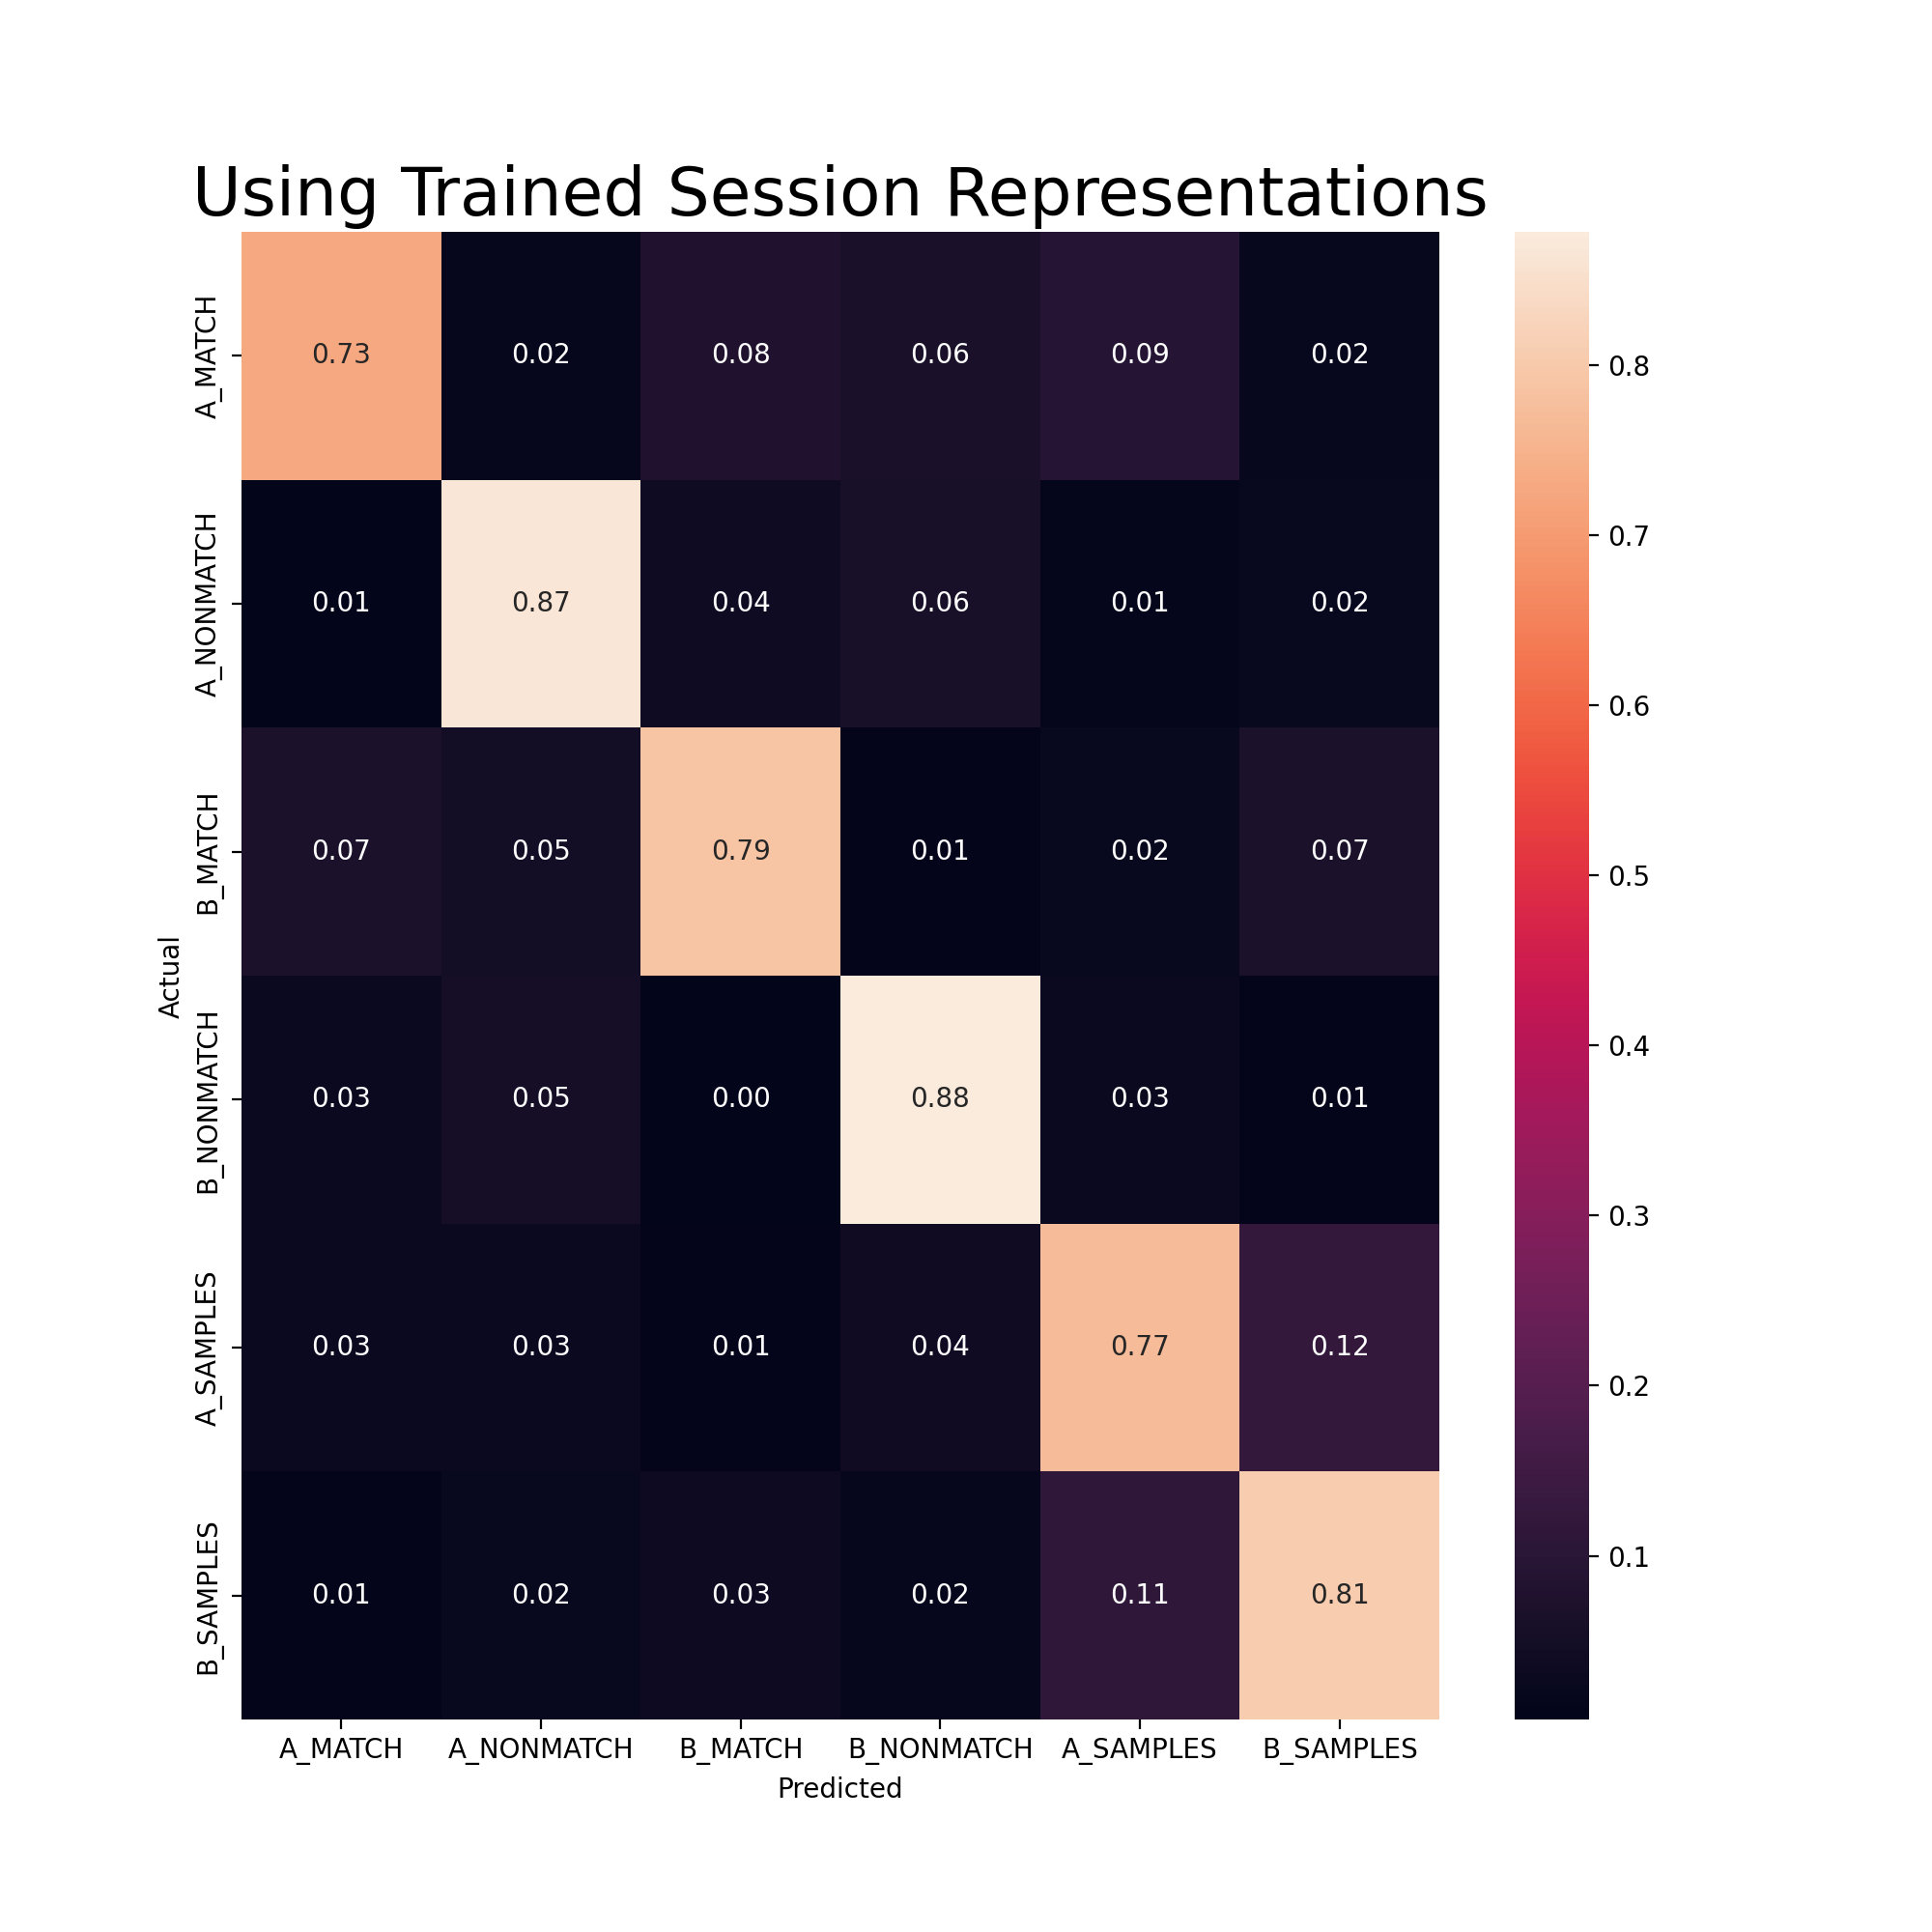

In [83]:
for i in np.arange(1, mod_num+1):
    cm = np.load(data_dir + '/neuronModel/cm_' + str(i) + '.npy')

    # Normalize the confusion matrix to between 0 and 1
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,10))
    sn.heatmap(cmn, annot=True, fmt='.2f', xticklabels=includeName, yticklabels=includeName)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(modelType[i-1], fontsize = 25)
#     plt.show(block=False)
    plt.savefig(data_dir + '/analysisGraphics/cm_' + str(i) + '.jpg')

## Accuracy & Predictions

In [26]:
pred = loadnpz(data_dir + '/neuronModel/prediction_7.npz')
accu = np.load(data_dir + '/neuronModel/accuracy_7.npy')
print(np.mean(accu))
print(len(accu))

0.7930813250841912
59


In [86]:
accu_results = [] 

for i in np.arange(1, mod_num+1):
    accu = np.load(data_dir + '/neuronModel/accuracy_' + str(i) + '.npy')
    print(np.shape(accu))
    accu_results.append([modelType[i-1], np.mean(accu)])
    
accu_results = pd.DataFrame(accu_results).set_index(np.arange(1,5))
accu_results.rename(columns={0: 'Models', 1: 'Mean Accuracy'}, inplace=True)
accu_results.to_csv(data_dir + '/analysisGraphics/AccuracySummary.csv')


(1,)
(519,)
(1,)
(519,)


In [66]:
accu_results

,Models,Mean Accuracy
1,No Session Representations,0.545274
2,With Session Representations,0.821759
3,Rat Specific Representations*,0.555388
4,Using Trained Session Representations,0.819193


In [32]:
print(pred)
print(np.shape(pred))

[[ -0.10164356   1.2561979   -1.1550438    6.8123426    0.09311152
   -5.996398  ]
 [ -5.175662    -4.8206906   -5.9323997   -1.9394069    8.71078
    9.111029  ]
 [-16.059534    -5.130368   -10.299527    -4.452178     8.275221
   14.8672285 ]
 ...
 [  7.2156672   -0.6511431    0.5983931   13.998526    -3.4559522
   -7.189349  ]
 [  0.6793003   -7.9168224    0.10989618  -9.152895     0.01795149
    5.769738  ]
 [  4.81916     -1.3242118    7.8387113   -3.9213712   -3.4278493
   -0.8117604 ]]
(19183, 6)


## Representatioin (codeModel)

code torch.Size([59, 20])


<IPython.core.display.Javascript object>


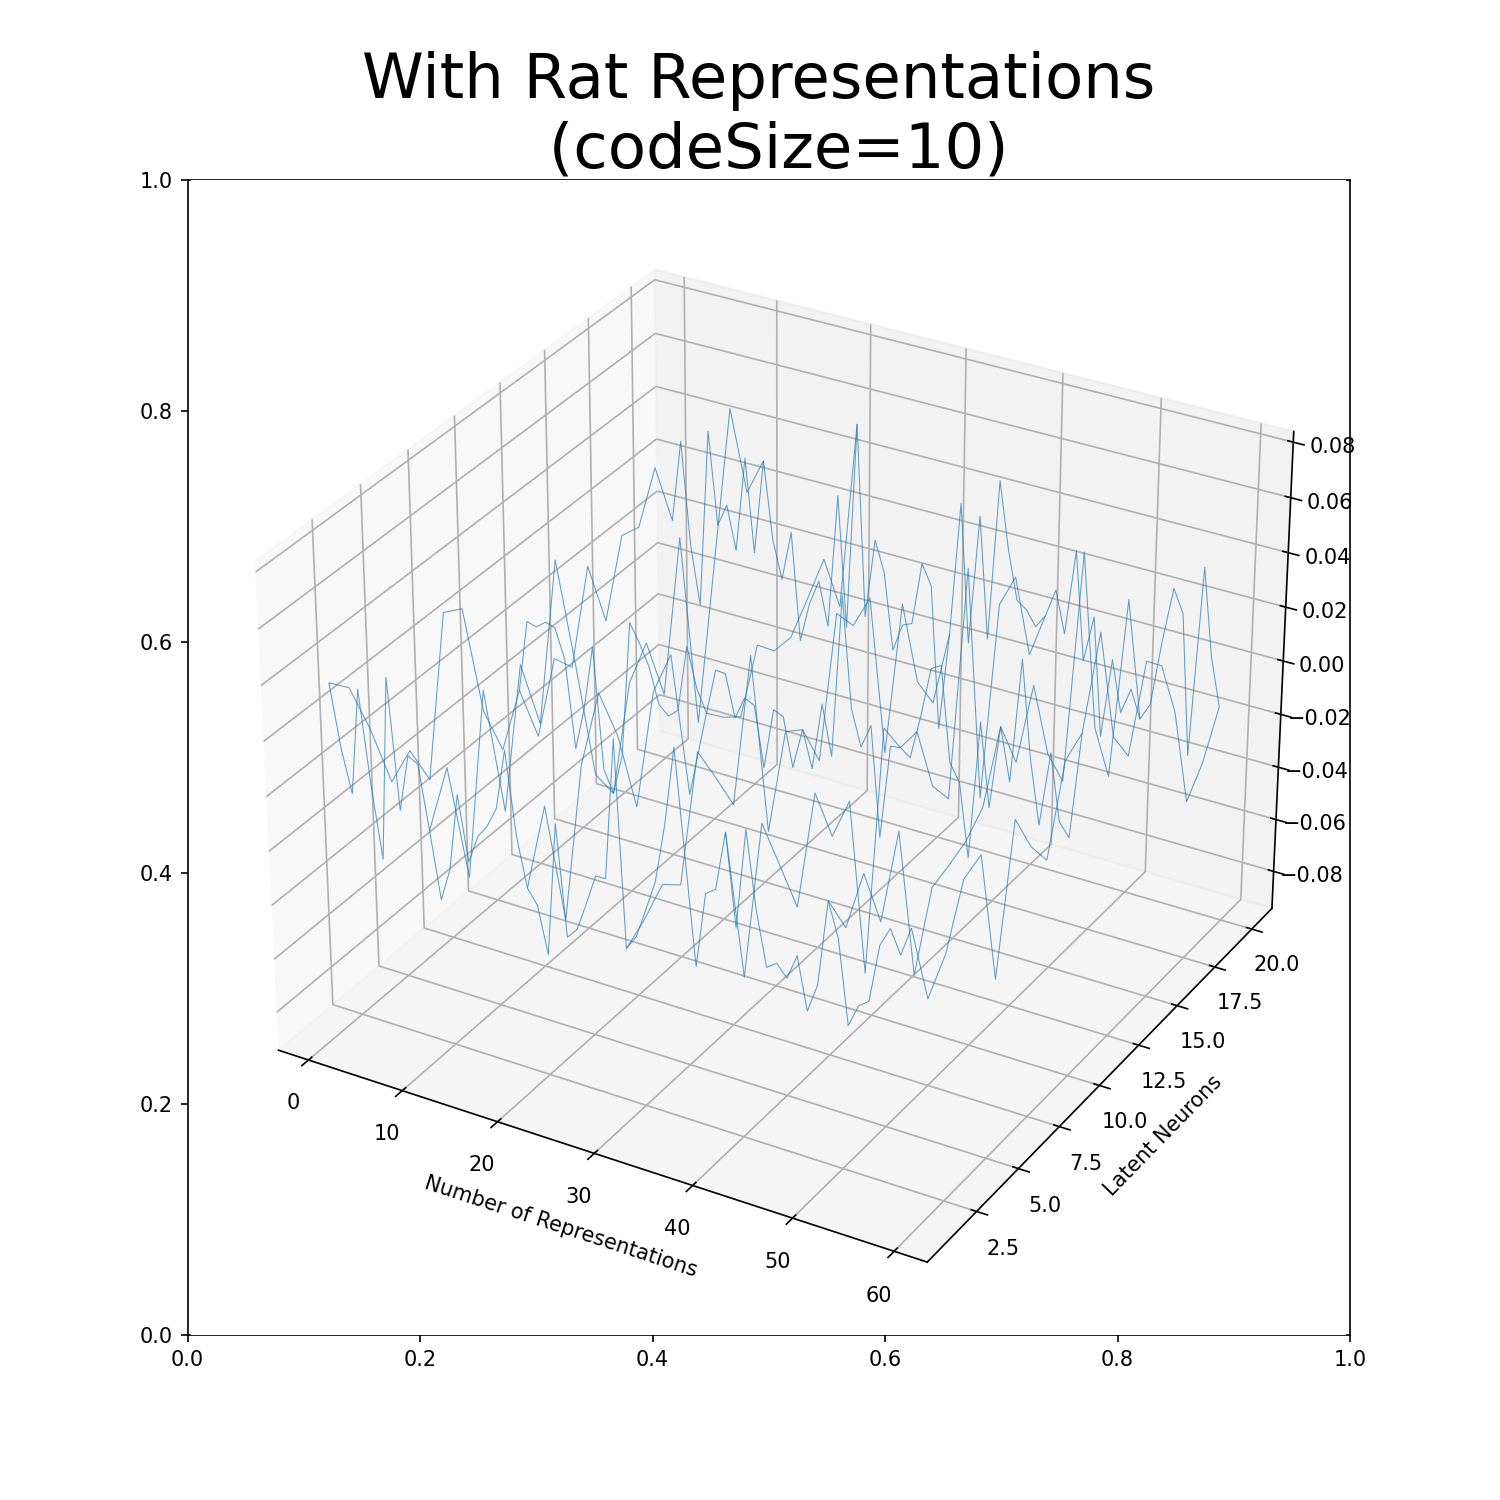

In [29]:
codeModel = torch.load(data_dir + '/neuronModel/codeModel_7.pt')
for name, param in codeModel.named_parameters():
    print(name, param.size())
#     print(param[0,:])
#     print(param[1,:])
    z = param.detach().numpy()
#         print("Number of Rows: ", len(z))
#         print("Number of Columns: ", len(z[0]))
    xdata = np.array([np.linspace(1,len(z), len(z))]*len(z[0])).T #.flatten()
    ydata = np.array([np.linspace(1,len(z[0]),len(z[0]))]*len(z))#.flatten()
    zdata = z

    fig, ax = plt.subplots(figsize=(10,10))
    ax = plt.axes(projection='3d')
    rep = ax.plot_wireframe(xdata, ydata, zdata, rstride=10, cstride=10, linewidth=0.5, alpha = 0.7)
    plt.title("With Rat Representations \n (codeSize=" + len(z[]")", fontsize = 30)
    plt.xlabel('Number of Representations')
    plt.ylabel('Latent Neurons')

## Other Parameters of Model

In [75]:
for name, param in model.named_parameters():
    print(name, param.size())

filter1.weight torch.Size([20, 1, 1, 20])
filter1.bias torch.Size([20])
filter2.weight torch.Size([5, 20, 1, 1])
filter2.bias torch.Size([5])
linCode0.weight torch.Size([20, 20])
linCode0.bias torch.Size([20])
linCode1.weight torch.Size([1680, 20])
linCode1.bias torch.Size([1680])
linCell0.weight torch.Size([20, 20])
linCell0.bias torch.Size([20])
linCell1.weight torch.Size([304, 20])
linCell1.bias torch.Size([304])
lin1.weight torch.Size([6, 500])
lin1.bias torch.Size([6])


## Scratch Section

In [ ]:
def savePrediction(data_dir):

    #This function does some analysis of predictions

    print ('savePrediction')


    def trainLinear(X, Y):




        n_split = 10
        argPerm = np.random.permutation(Y.shape[0])
        X = X[argPerm]
        Y = Y[argPerm]

        for a in range(X.shape[1]):
            X[:, a] = X[:, a] - np.mean(X[:, a])

        pred_test = np.zeros(Y.shape[0])



        #from sklearn.linear_model import LinearRegression
        from sklearn.linear_model import Lasso
        from sklearn.model_selection import KFold


        alpha1 = 0.001
        #alpha1 = 0.0001

        kf = KFold(n_splits=n_split)
        for train_index, test_index in kf.split(X):

            print ('a')

            clf = Lasso(alpha=alpha1)
            clf.fit(X[train_index], Y[train_index])

            pred_mini = clf.predict(X[test_index])
            pred_test[test_index] = np.copy(pred_mini)

        clf = Lasso(alpha=alpha1)
        clf.fit(X, Y)
        pred_train = clf.predict(X)

        print (np.mean(Y[np.argsort(pred_test)[-10:]  ]))


        print (scipy.stats.pearsonr(pred_train, Y))
        print (scipy.stats.pearsonr(pred_test, Y))

        quit()



    #includeName = ['A_MATCH', 'A_NONMATCH', 'B_MATCH', 'B_NONMATCH', 'A_SAMPLES', 'B_SAMPLES']



    wireName = loadnpz(data_dir + '/eventData/general/wireNames.npz')


    X = loadnpz(data_dir + '/eventData/combined/data8.npz') #7
    Y = loadnpz(data_dir + '/eventData/combined/outputType8.npz')
    dataKeys = loadnpz(data_dir + '/eventData/combined/keys8.npz')

    disableCodes = False


    numDataSet = int(np.max(dataKeys) + 1)


    Ndata = X.shape[0]
    #Ndata = originalSize
    Ntest = Ndata // 5
    Ntrain = Ndata - Ntest
    #argTrain = np.random.permutation(Ndata)
    argTrain = loadnpz(data_dir + '/eventData/combined/argTrain.npz')

    modelNum = 11


    if modelNum == 3:
        locNames = loadnpz(data_dir + '/eventData/general/brainLocationNames.npz')
        X[:, locNames==0] = 0

    elif modelNum == 4:
        locNames = loadnpz(data_dir + '/eventData/general/brainLocationNames.npz')
        X[:, locNames==1] = 0







    argTest = argTrain[:Ntest]


    X_test = torch.tensor(X[argTest]).float()
    Y_test = Y[argTest].astype(int)
    dataKeys_test = dataKeys[argTest]


    #Y_test = Y_test[np.argsort(argTest)]




    if modelNum in [0, 3, 4]:
        #argTrain = argTrain[Ntest:]
        #X = torch.tensor(X[argTrain]).float()
        #Y = torch.tensor(Y[argTrain]).long()
        #dataKeys = dataKeys[argTrain]

        if modelNum == 0:
            model = torch.load(data_dir + '/neuronModel/model_16.pt')
            codeModel = torch.load(data_dir + '/neuronModel/codeModel_16.pt')
        elif modelNum == 3:
            model = torch.load(data_dir + '/neuronModel/model_1_noCA1.pt')
            codeModel = torch.load(data_dir + '/neuronModel/codeModel_1_noCA1.pt')

        elif modelNum == 4:
            model = torch.load(data_dir + '/neuronModel/model_1_noCA3.pt')
            codeModel = torch.load(data_dir + '/neuronModel/codeModel_1_noCA3.pt')

        test_losses = []


        if disableCodes:
            codes = torch.FloatTensor(np.zeros((X_test.shape[0], codeSize)))
        else:
            codes = codeModel(dataKeys_test) #* 0


        pred = model(X_test, codes)
        pred = pred.data.numpy()
        pred = pred[:, :6]

    if modelNum == 1:
        pred = loadnpz(data_dir + '/manyModels/rat1/prediction.npz')

    if modelNum == 2:
        pred = loadnpz(data_dir + '/manyModels/rat2/prediction.npz')

    if modelNum == 5:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_time3to5.npz')

    if modelNum == 6:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_time5to3.npz')

    if modelNum == 7:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_time3to3.npz')

    if modelNum == 8:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_time3to1.npz')

    if modelNum == 9:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_time1to3.npz')

    if modelNum == 10:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_time1to1.npz')

    if modelNum == 11:
        pred = loadnpz(data_dir + '/neuronModel/prediction_1_noCenter.npz')



    #pred_prob = torch.softmax(torch.tensor(pred).float(), dim=1).data.numpy()

    #X_test = X_test.data.numpy()
    #rand1 = np.random.permutation(pred_prob.shape[0])

    #argsort_class1 = np.argsort( np.max(pred_prob[:, np.array([1, 3]) ] ,axis=1 ) )[-1::-1]
    #argsort_class2 = np.argsort( np.max(pred_prob[:, np.array([0, 2]) ] ,axis=1 ) )[-1::-1]



    #for a in range(argsort_class1.shape[0]):

        #print (a)
    #plt.imshow(np.mean(X_test[argsort_class1[:40]], axis=0))
    #plt.show()

    #plt.imshow(np.mean(X_test[argsort_class2[:40]], axis=0))
    #plt.show()

    #quit()



    #pred = pred_prob

    pred_correct = np.argmax(pred[:, :4], axis=1).astype(int)
    pred = np.argmax(pred, axis=1).astype(int)


    _, counts1 = np.unique(Y_test, return_counts=True)
    #print ('zero acc', np.max(counts1) / np.sum(counts1) )


    cat_AB = np.array([0, 0, 1, 1, 0, 1]).astype(int)
    cat_sample = np.array([0, 0, 0, 0, 1, 1]).astype(int)
    cat_correct = np.array([0, 1, 0, 1, 2, 2]).astype(int)
    cat_decide = np.array([0, 1, 1, 0, 2, 2]).astype(int)


    pred_AB = cat_AB[pred]
    true_AB = cat_AB[Y_test]
    diff_AB = np.abs(pred_AB - true_AB)

    pred_sample = cat_sample[pred]
    true_sample = cat_sample[Y_test]
    diff_sample = np.abs(pred_sample - true_sample)

    pred_correct = cat_correct[pred_correct]
    true_correct = cat_correct[Y_test]
    diff_correct = np.abs(pred_correct - true_correct)
    diff_correct = diff_correct[true_correct != 2]
    key_correct = dataKeys_test[true_correct != 2]

    pred_decide = cat_decide[pred]
    true_decide = cat_decide[Y_test]
    diff_decide = np.abs(pred_decide - true_decide)
    diff_decide = diff_decide[diff_decide != 2]
    key_decide = dataKeys_test[true_decide != 2]



    print (1 - np.mean(diff_AB))
    print (1 - np.mean(diff_sample))
    print (1 - np.mean(diff_correct))
    print (1 - np.mean(diff_decide))
    #quit()



    diff = Y_test - pred
    accuracy_test = np.argwhere(diff == 0).shape[0] / diff.shape[0]
    print (accuracy_test)



    quit()

    #confusion_matrix = np.zeros((pred.shape[0], 6, 6))
    #confusion_matrix[np.arange(pred.shape[0]),  pred.astype(int), Y_test.astype(int) ] = 1
    #confusion_matrix = np.sum(confusion_matrix, axis=0)
    #confusion_matrix = confusion_matrix.astype(int)


    #print (confusion_matrix)

    #print ("A")


    accuracySession = []
    accuracySession_AB = []
    accuracySession_sample = []
    accuracySession_correct = []
    sessionTrialNum = []
    correctPercent = []
    #accuracySession = []
    for b in range(numDataSet):
        args1 = np.argwhere(dataKeys_test == b)[:, 0]
        acc_ses = np.argwhere(diff[args1] == 0).shape[0] / args1.shape[0]
        acc_ses_AB = 1 - np.mean(diff_AB[args1])
        acc_ses_sample = 1 - np.mean(diff_sample[args1])
        num_trail = int(np.sum(true_sample[args1]))

        sessionTrialNum.append(num_trail)
        accuracySession.append(acc_ses)
        accuracySession_AB.append(acc_ses_AB)
        accuracySession_sample.append(acc_ses_sample)

        args1_correct = np.argwhere(key_correct == b)[:, 0]
        correct_percent = np.mean(true_correct[args1_correct])
        correctPercent.append(correct_percent)

        acc_ses_correct = 1 - np.mean(diff_correct[args1_correct])
        accuracySession_correct.append(acc_ses_correct)

    #np.save('./data/neuronModel/accuracy_16.npy', accuracySession)
    accuracySession = np.array(accuracySession)
    accuracySession_AB = np.array(accuracySession_AB)
    accuracySession_correct = np.array(accuracySession_correct)



    validArgs = loadnpz(data_dir + '/eventData/seperate/validArgs8.npz')


    sensorLocation = loadnpz(data_dir + '/eventData/combined/inputLocation' + str(8) + '.npz')
    sensorNum = np.sum(sensorLocation, axis=1)


    locNames = loadnpz(data_dir + '/eventData/general/brainLocationNames.npz')
    #locNames = locNames.repeat(sensorLocation.shape[0]).reshape((locNames.shape[0], sensorLocation.shape[0])).T
    #locNames = 1 - locNames
    #sensorNum1 = np.sum(sensorLocation * locNames, axis=1)
    #sensorNum = sensorNum1

    sensorX = np.concatenate((  sensorNum.reshape((sensorNum.shape[0], 1)) , sensorLocation ), axis=1)

    print (accuracySession_AB.shape)
    print (sensorX.shape)

    print (np.mean(accuracySession_correct  ))
    print (np.mean(accuracySession_correct[np.argsort(sensorNum)[-50:]]  ))
    print (np.mean(accuracySession_correct[np.argsort(sensorNum)[-20:]]  ))
    print (np.mean(accuracySession_correct[np.argsort(sensorNum)[-10:]]  ))
    quit()

    trainLinear(sensorX, accuracySession_correct)
    quit()

    print ('')
    #for a in range(sensorLocation.shape[1]):
    #    print (scipy.stats.pearsonr(sensorLocation[:, a], accuracySession))
    #quit()

    print (scipy.stats.pearsonr(correctPercent, accuracySession))
    print (scipy.stats.pearsonr(correctPercent, accuracySession_AB))
    print (scipy.stats.pearsonr(correctPercent, accuracySession_sample))


    #plt.xlabel('Number of Inputs')
    #plt.ylabel("Accuracy")
    plt.scatter(sensorNum1, accuracySession)
    plt.show()
    plt.scatter(sensorNum1, accuracySession_AB)
    plt.show()
    plt.scatter(sensorNum1, accuracySession_sample)
    #plt.scatter(ratSen, ratAcc)
    plt.show()

In [ ]:
savePrediction(data_dir)